# Hindcast nitrate summary

For upwelling manuscript, Moore-Maley et al. in prep

***

In [502]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yaml
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm.notebook import tqdm
from glob import glob
from salishsea_tools import viz_tools
from salishsea_tools.places import PLACES

%matplotlib inline

In [513]:
plt.rcParams['font.size'] = 12

In [531]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, _, _ = yaml.safe_load_all(f)
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/local/'
colors = ['powderblue', 'steelblue', 'orange', 'mistyrose']
y, x = [slice(*subdomains['NO3'][slice(*pair)]) for pair in [(2, 4), (0, 2)]]
tmask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').tmask[0, 0, ...]
stations = {
    'Campbell River': (730, 125),
    'Texada': (637, 175),
    'Parksville': (546, 174),
    'Point Roberts': (370, 300),
}

In [265]:
# Load wind
masklims = [
    [(31, 45), (50, 30), (69, 8)],
    [(35, 48), (53, 31), (71, 12)],
    [(38, 48), (57, 30)],
]
imasklim = [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
window = signal.get_window('blackman', 121)
wind = np.empty(0)
for file, ilim in zip(tqdm(sorted(glob(path + 'HRDPS*'))), imasklim):
    with xr.open_dataset(file) as ds:
        
        # Meshmask
        mask = ds.meshmask.values
        mask[:20, :20] = 0
        for lim in masklims[ilim]:
            mask[lim[0]:, lim[1]:] = 0
        mask = mask.reshape(-1).astype('bool')

        # Alongaxis wind
        u, v = [ds[var].values.reshape(-1, len(mask))[:, mask] for var in ['u_wind', 'v_wind']]
        jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180))

        # Process and concatenate
        wind = np.concatenate((wind, (jtau * np.sqrt(u**2 + v**2)).mean(axis=1)))

# Build time index
wind = signal.convolve((wind, window / sum(window), mode='same')
time = np.array([datetime(2010, 1, 1) + timedelta(hours=hour) for hour in range(len(wind))])

In [523]:
# Load nitrate
window = signal.get_window('blackman', 121)
nitrate, nitrate_smooth = {}, {}
for station in stations: nitrate[station] = np.empty(0)
for file in tqdm(sorted(glob(path + 'SalishSea*'))):
    with xr.open_dataset(file) as ds:
        for station in stations:
            j, i = [coord - subdomains['NO3'][i] for coord, i in zip(stations[station], [2, 0])]
            nitrate[station] = np.concatenate((nitrate[station], ds.nitrate[:, j, i].values))
for station in stations:
    nitrate_smooth[station] = signal.convolve(nitrate[station], window / sum(window), mode='same')

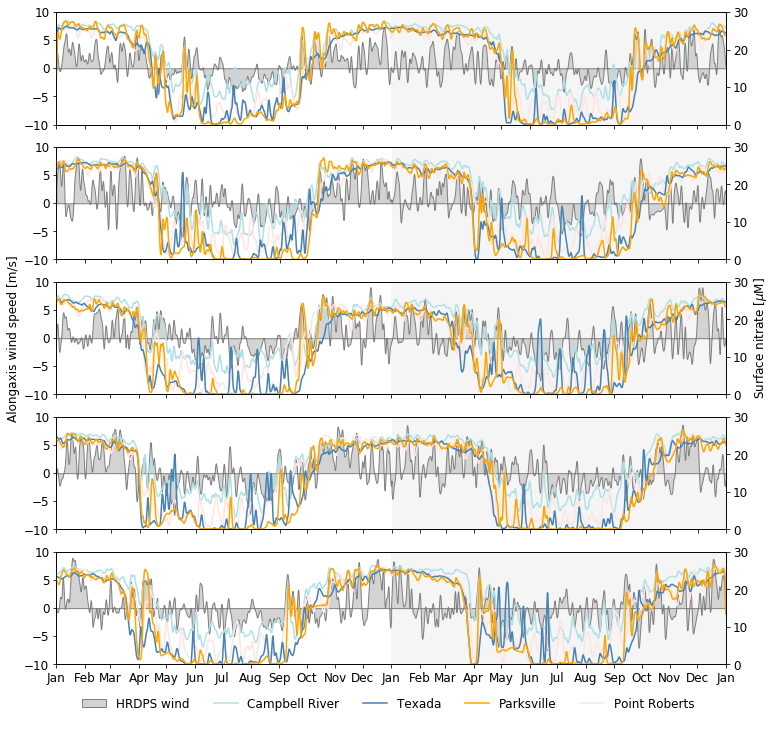

In [586]:
fig, axs = plt.subplots(5, 1, figsize=(12, 12))
l = [0, 0, 0, 0, 0]
for ax, year in zip(axs, range(2010, 2020, 2)):
    index = [abs(time - datetime(year+y, 1, 1)).argmin() for y in [0, 2]]
    l[0] = ax.fill_between(time[slice(*index)], wind[slice(*index)], facecolor='lightgray', edgecolor='gray')
    ax.add_patch(Rectangle((datetime(year+1, 1, 1), -10), timedelta(days=366), 20, facecolor='whitesmoke', zorder=-10))
    ax2 = ax.twinx()
    ax2.set_ylim([0, 30])
    for i, station, color, zorder in zip(range(1, 5), stations, colors, [1, 2, 2, 1]):
        l[i], = ax2.plot(time[slice(*index)], nitrate_smooth[station][slice(*index)], color=color, label=station, zorder=zorder)
    ax.set_xlim([datetime(year, 1, 1), datetime(year+2, 1, 1)])
    ax.set_ylim([-10, 10])
    ax.xaxis.set_major_locator(getattr(mdates, f'MonthLocator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    if year < 2018: ax.xaxis.set_ticklabels('')
    if year == 2014:
        ax.set_ylabel('Alongaxis wind speed [m/s]')
        ax2.set_ylabel('Surface nitrate [$\mu$M]')
fig.legend(l, ['HRDPS wind'] + list(stations.keys()), ncol=5, loc=[0.1, 0.04], frameon=False)
fig.savefig('/home/bmoorema/Desktop/Newfigs/timeseries.pdf', bbox_inches='tight')

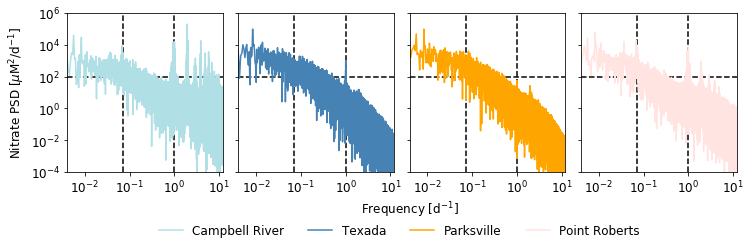

In [587]:
# Plot surface nitrate PSD at coastal stations
fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), gridspec_kw={'wspace': 0.1})
xlim, ylim, n = [4e-3, 12], [1e-4, 1e6], len(time)
freq = np.linspace(-12, 12, n)
peaks = [1, 14]
l = [0, 0, 0, 0]
for i, ax, station, color in zip(range(4), axs, stations, colors):
    ax.plot(xlim, [1e2, 1e2], 'k--')
    for peak in peaks: ax.plot([1 / peak, 1 / peak], ylim, 'k--')
    PSD = abs(fftshift(fft(nitrate[station])))**2 / 86400
    l[i], = ax.plot(freq, PSD, '-', color=color, label=station)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_ticks([1e-2, 1e-1, 1, 10])
    if station == 'Campbell River':
        ax.set_ylabel('Nitrate PSD [$\mu$M$^2/$d$^{-1}$]')
        ax.set_xlabel('Frequency [d$^{-1}$]', x=2.2)
    else: ax.yaxis.set_ticklabels('')
fig.legend(l, list(stations.keys()), ncol=5, loc=[0.205, 0], frameon=False)
plt.subplots_adjust(bottom=0.25)
fig.savefig('/home/bmoorema/Desktop/Newfigs/spectra.pdf', bbox_inches='tight')

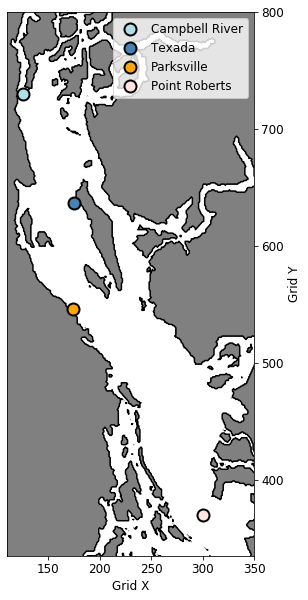

In [607]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.contourf(tmask, levels=[-0.01, 0.01], colors='gray')
ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
for station, color in zip(stations, colors):
    ax.plot(*stations[station][::-1], 'ko', markersize=12, markeredgewidth=2, markerfacecolor=color, label=station)
ax.set_xlim([110, 350])
ax.set_ylim([335, 800])
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
viz_tools.set_aspect(ax)
ax.legend()
fig.savefig('/home/bmoorema/Desktop/Newfigs/stations.pdf', bbox_inches='tight')